## Imports

In [77]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns


from helpers import load_raw_data

## Load data

In [2]:
#path = '../input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
path = 'ptb-xl_ecg/'

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(df = Y, path=path)

100%|██████████| 21837/21837 [10:09<00:00, 35.81it/s]


## Initial analysis

In [3]:
print('X shape:', X.shape)
print('Y shape:', Y.shape, '\n')

print(Y.columns, '\n')

print('Unique classes:', Y['scp_codes'].explode().unique(), '\n')

print(Y.head())

X shape: (21837, 1000, 12)
Y shape: (21837, 27) 

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object') 

Unique classes: ['NORM' 'LVOLT' 'SR' 'SBRAD' 'IMI' 'ABQRS' 'SARRH' 'AFLT' 'AFIB' 'NDT'
 'NST_' 'DIG' 'LVH' 'LPFB' 'LNGQT' 'LAFB' 'IRBBB' 'RAO/RAE' 'RVH' 'IVCD'
 'LMI' 'ASMI' 'AMI' 'ISCAL' '1AVB' 'STACH' 'ISC_' 'PACE' 'ISCLA' 'SEHYP'
 'ISCIL' 'ILMI' 'PVC' 'CRBBB' 'CLBBB' 'ALMI' 'ANEUR' 'ISCAS' 'TAB_'
 'HVOLT' 'PAC' 'LOWT' 'STD_' 'EL' 'NT_' 'QWAVE' 'INVT' 'LPR' 'VCLVH'
 'LAO/LAE' 'ILBBB' 'ISCIN' 'SVTAC' 'INJAS' 'INJAL' 'IPMI' 'WPW' 'ISCAN'
 'INJLA' 'BIGU' 'TRIGU' 'IPLMI' '

We obviously have some columns here that we cannot use for features. The ones we can remove on the go are:
- patient_id: the unique identifier for each patient, not useful as a feature
- recording_date: the date of the recording, not useful as a feature in this format
- report: the text of the report, which we will not use directly as a feature
- filename_lr: the filename of the left eye image, not useful as a feature
- filename_hr: the filename of the right eye image, not useful as a feature

Let's first look at the remaining colums that has multiple values:

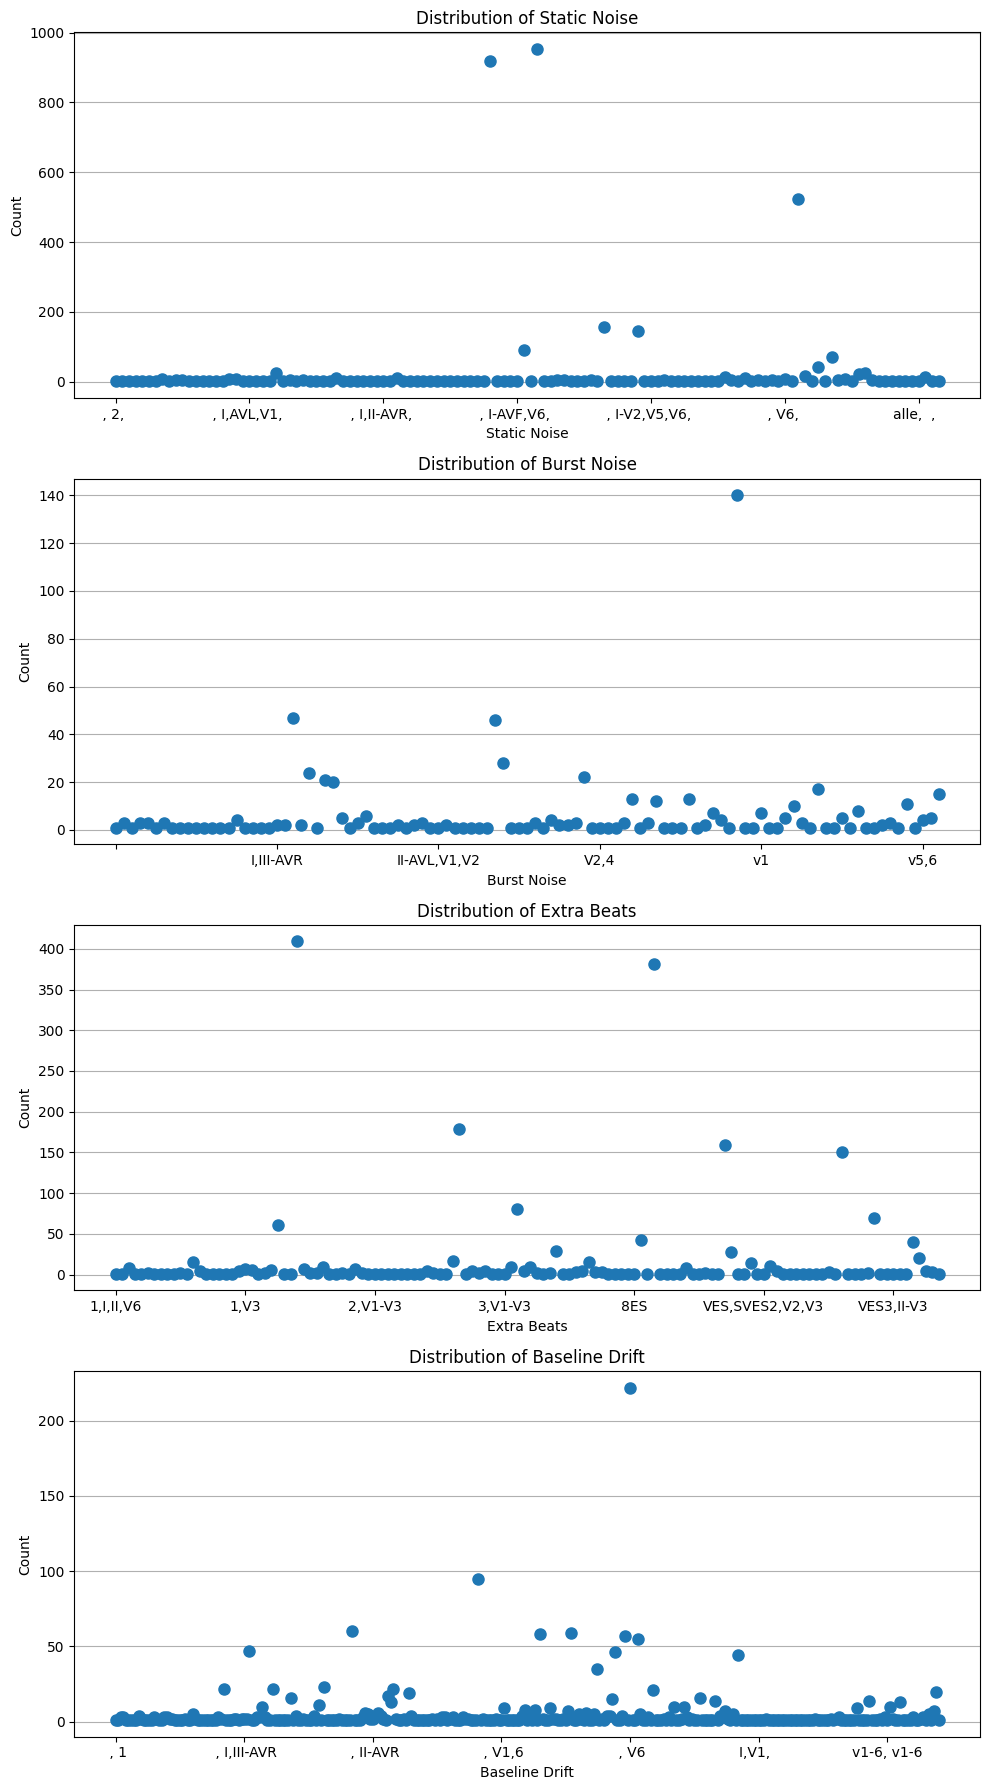

In [62]:
fig, axes = plt.subplots(4, 1, figsize=(10, 18))

Y['static_noise'].value_counts().sort_index().plot(
    style='o', markersize=8, linestyle='None', ax=axes[0])
axes[0].set_title('Distribution of Static Noise')
axes[0].set_xlabel('Static Noise')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')

Y['burst_noise'].value_counts().sort_index().plot(
    style='o', markersize=8, linestyle='None', ax=axes[1])
axes[1].set_title('Distribution of Burst Noise')
axes[1].set_xlabel('Burst Noise')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y')

Y['extra_beats'].value_counts().sort_index().plot(
    style='o', markersize=8, linestyle='None', ax=axes[2])
axes[2].set_title('Distribution of Extra Beats')
axes[2].set_xlabel('Extra Beats')
axes[2].set_ylabel('Count')
axes[2].grid(axis='y')

Y['baseline_drift'].value_counts().sort_index().plot(
    style='o', markersize=8, linestyle='None', ax=axes[3])
axes[3].set_title('Distribution of Baseline Drift')
axes[3].set_xlabel('Baseline Drift')
axes[3].set_ylabel('Count')
axes[3].grid(axis='y')

plt.tight_layout()
plt.show()


Due to lack of understanding of the medical domain, and the fact that these are multiple values, we will not use the latter columns as features for now.

Let's look at the remaining columns:

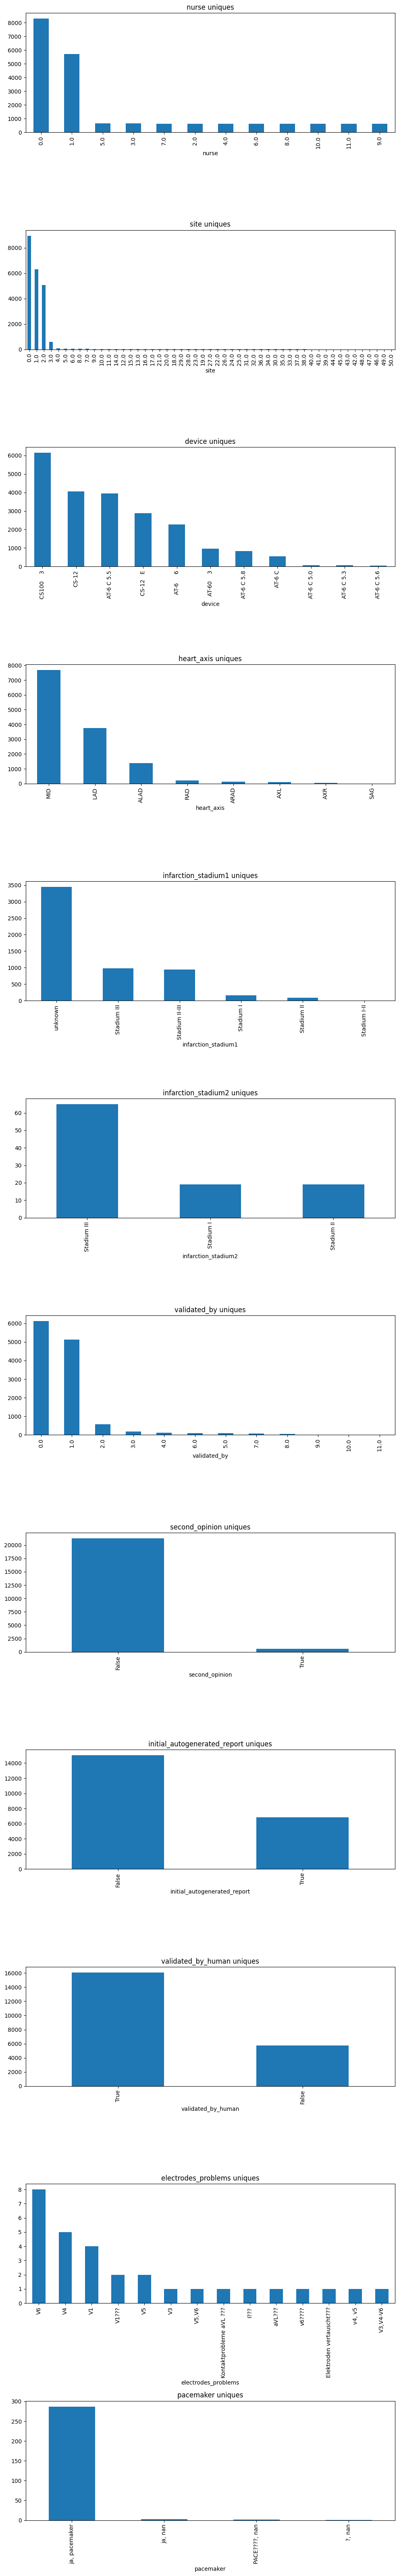

In [63]:
fig, axes = plt.subplots(12, 1, figsize=(10, 64))

Y['nurse'].value_counts().plot(kind='bar', ax=axes[0], title='nurse uniques')
Y['site'].value_counts().plot(kind='bar', ax=axes[1], title='site uniques')
Y['device'].value_counts().plot(kind='bar', ax=axes[2], title='device uniques')
Y['heart_axis'].value_counts().plot(kind='bar', ax=axes[3], title='heart_axis uniques')
Y['infarction_stadium1'].value_counts().plot(kind='bar', ax=axes[4], title='infarction_stadium1 uniques')
Y['infarction_stadium2'].value_counts().plot(kind='bar', ax=axes[5], title='infarction_stadium2 uniques')
Y['validated_by'].value_counts().plot(kind='bar', ax=axes[6], title='validated_by uniques')
Y['second_opinion'].value_counts().plot(kind='bar', ax=axes[7], title='second_opinion uniques')
Y['initial_autogenerated_report'].value_counts().plot(kind='bar', ax=axes[8], title='initial_autogenerated_report uniques')
Y['validated_by_human'].explode().value_counts().plot(kind='bar', ax=axes[9], title='validated_by_human uniques')
#Y['baseline_drift'].value_counts().plot(kind='bar', ax=axes[10], title='baseline_drift uniques')
#Y['static_noise'].value_counts().plot(kind='bar', ax=axes[11], title='static_noise uniques')
#Y['burst_noise'].value_counts().plot(kind='bar', ax=axes[12], title='burst_noise uniques')
Y['electrodes_problems'].value_counts().plot(kind='bar', ax=axes[10], title='electrodes_problems uniques')
#Y['extra_beats'].value_counts().plot(kind='bar', ax=axes[14], title='extra_beats uniques')
Y['pacemaker'].value_counts().plot(kind='bar', ax=axes[11], title='pacemaker uniques')


plt.tight_layout()
plt.show()

Out of these, we choose the columns related to data aquisition as features, and leave the rest for now. The feature columns we will use are:

In [64]:
meta_features = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']

('age', 'sex', 'height' and 'weight' we will obviously use as features, as they are basic demographic information about the patient)

Other highly relevant columns that will not used for modeling are:
- strat_fold: these will be used for cross-validation and splitting of the DS
- ecg_id: id for the raw ECG data, will be kept as reference but SHOULD NOT be used as a feature

Now lets analyze our labels and label-data

## Heart Beat Diagnostic data

In [ ]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print(agg_df.shape)
agg_df.head()

(44, 12)


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


- NOTE: only 44 of the original 71 statements are diagnostics and will be used

### Applying diagnostic superclass

In [13]:
def aggregate_superclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_superclass_diagnostic)
# Apply length of diagnostic superclass
Y['diagnostic_superclass_len'] = Y['diagnostic_superclass'].apply(len)
Y.loc[Y.diagnostic_superclass_len > 1, 'diagnostic_superclass']

ecg_id
39       [MI, STTC]
45        [CD, HYP]
50         [MI, CD]
77         [MI, CD]
87       [STTC, CD]
            ...    
21815      [MI, CD]
21821    [CD, NORM]
21827    [MI, STTC]
21828    [MI, STTC]
21829    [CD, NORM]
Name: diagnostic_superclass, Length: 5158, dtype: object

Distribution of diagnostic superclasses:


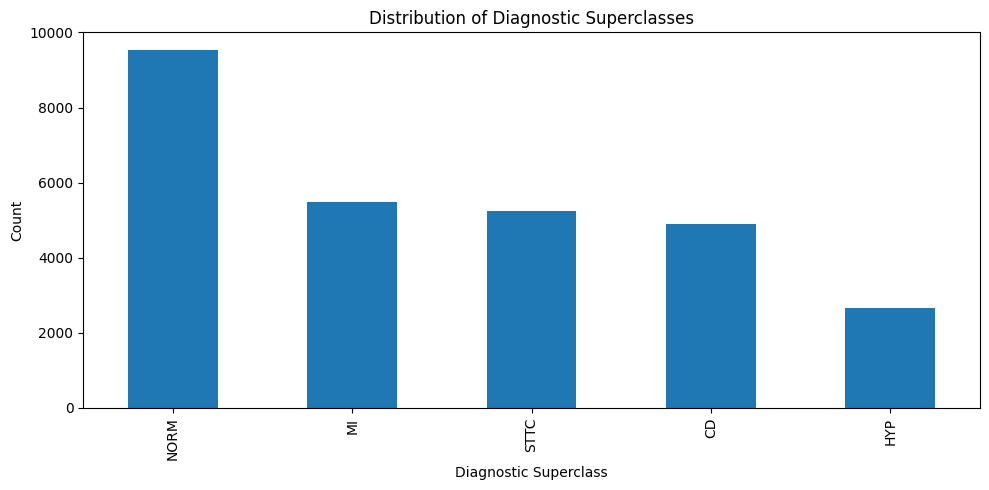

In [66]:
# Find the distribution of the diagnostic superclasses
print('Distribution of diagnostic superclasses:')
Y['diagnostic_superclass'].explode().value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Diagnostic Superclasses')
plt.xlabel('Diagnostic Superclass')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### Brief superclass description
- NORM: Normal ECG
- MI: Miocardial Infarction (heart attack)
- STTC: ST-T wave changes
- CD: Conduction disturbances. Disturbances in the electrical conduction system of the heart.
- HYP: Hypertrophy. Thickening of the heart muscle.

In [16]:
# Find the distribution of the Length of the diagnostic superclasses
print('Distribution of the Length of the diagnostic superclasses:')
print(Y['diagnostic_superclass_len'].value_counts(), '\n')

Distribution of the Length of the diagnostic superclasses:
diagnostic_superclass_len
1    16272
2     4079
3      920
0      407
4      159
Name: count, dtype: int64 



- Only 407 unclassified samples
- Up to 4 superclasses on the same ECG record

## Diagnostic Subclasses

In [ ]:
def aggregate_suberclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # Prefix all subclasses with 'sub_' to differentiate with superclasses
    return ret

# Apply diagnostic subclass
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_suberclass_diagnostic)
# Apply length of diagnostic subclass
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']


ecg_id
26                    [sub_STTC, sub_NST_]
28                    [sub_STTC, sub_NST_]
39           [sub_STTC, sub_IMI, sub_NST_]
45       [sub_RVH, sub_IRBBB, sub_RAO/RAE]
50                     [sub_IVCD, sub_LMI]
                       ...                
21821                [sub_IRBBB, sub_NORM]
21827                  [sub_IMI, sub_ISCA]
21828                  [sub_IMI, sub_ISCA]
21829                [sub_IRBBB, sub_NORM]
21832            [sub_LAFB/LPFB, sub_IVCD]
Name: diagnostic_subclass, Length: 6191, dtype: object

Distribution of diagnostic subclasses:


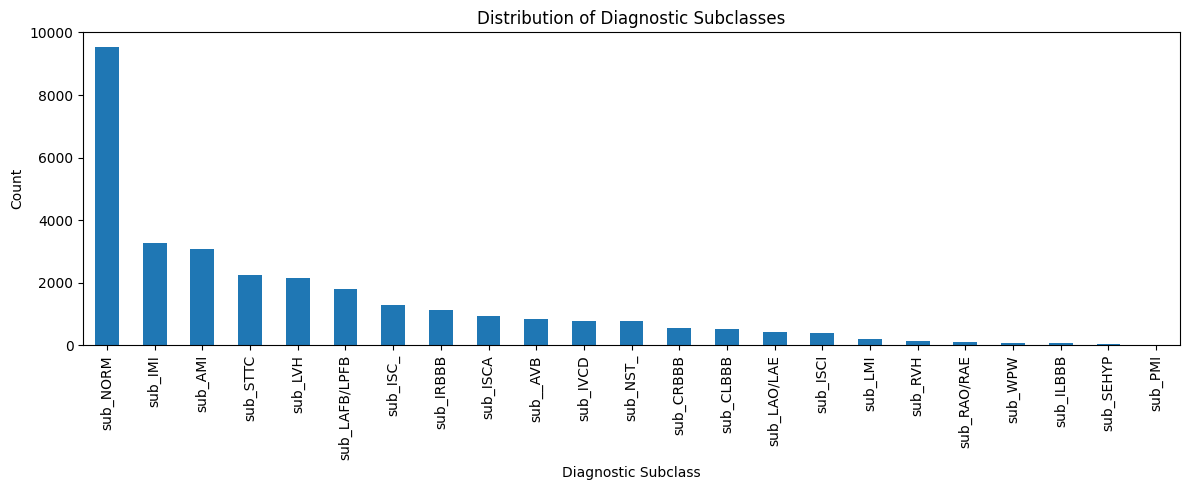

In [65]:
# Find the distribution of the diagnostic subclasses
print('Distribution of diagnostic subclasses:')
Y['diagnostic_subclass'].explode().value_counts().plot(kind='bar', figsize=(12, 5))
plt.title('Distribution of Diagnostic Subclasses')
plt.xlabel('Diagnostic Subclass')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [67]:
# Find the distribution of the Length of the diagnostic subclasses
print('Distribution of the Length of the diagnostic subclasses:')
print(Y['diagnostic_subclass_len'].value_counts(), '\n')


Distribution of the Length of the diagnostic subclasses:
diagnostic_subclass_len
1    15239
2     4171
3     1439
4      475
0      407
5      102
6        4
Name: count, dtype: int64 



In [69]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass', 'diagnostic_superclass_len',
       'diagnostic_subclass', 'diagnostic_subclass_len'],
      dtype='object')

## Data reformatting

- As per now, X includes only the 12 ECG signals for all patients
- Y includes all 71 original statements + our diagnostic super/subclasses and their lengths

Let's reformat the data to include our 'meta_features' and compose y of all the different superclasses and subclasses. We will keep everything in Y for now.

In [ ]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))
superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols])

update_cols

array(['NORM', 'MI', 'STTC', 'HYP', 'CD', 'sub_NORM', 'sub_IMI',
       'sub_STTC', 'sub_NST_', 'sub_LVH', 'sub_LAFB/LPFB', 'sub_RVH',
       'sub_IRBBB', 'sub_RAO/RAE', 'sub_IVCD', 'sub_LMI', 'sub_AMI',
       'sub__AVB', 'sub_ISCA', 'sub_ISC_', 'sub_SEHYP', 'sub_ISCI',
       'sub_CRBBB', 'sub_CLBBB', 'sub_LAO/LAE', 'sub_ILBBB', 'sub_WPW',
       'sub_PMI'], dtype=object)

In [113]:
# FOUND ONLINE
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, target_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should be longer than 0'
    filt = np.isin(y.strat_fold.values, folds)
    pos = np.where(filt)[0]
    x_selected = x[pos]
    y_selected = y.iloc[pos].copy()
    
    for sc in target_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(target_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(target_cols)+['strat_fold']]

In [114]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_features)

In [75]:
y_all

,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,1,...,0,0,0,0,0,0,0,0,0,7
21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,4
21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,1,...,0,0,0,0,0,0,0,0,0,2


## ECG examples

Normal example (NORM)

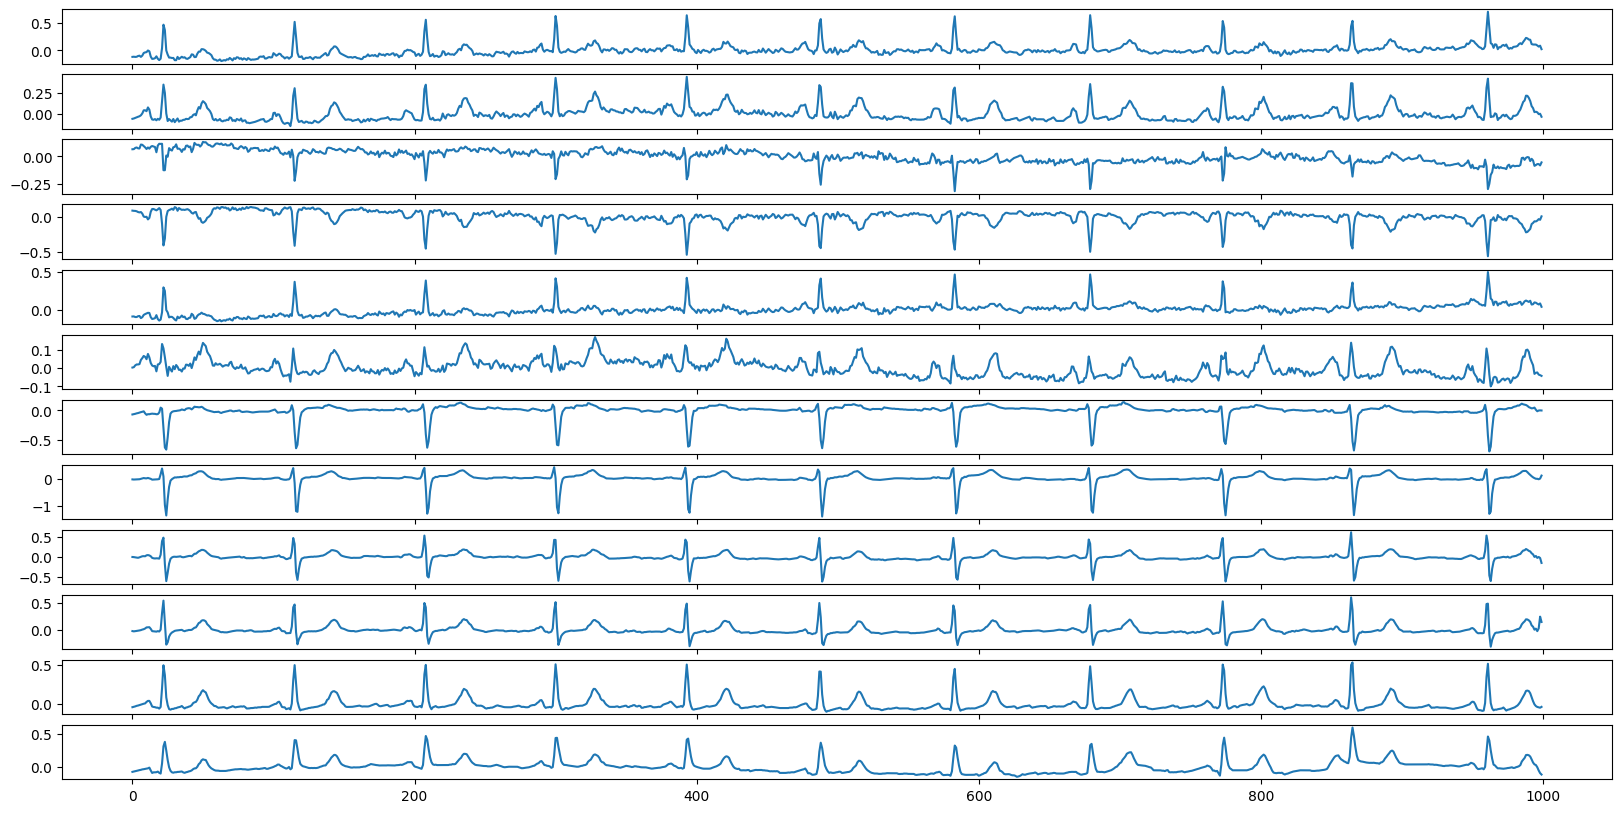

age                   19.0
sex                      0
height                 NaN
weight                70.0
nurse                  2.0
site                   0.0
device           CS-12   E
NORM                     1
MI                       0
STTC                     0
HYP                      0
CD                       0
sub_NORM                 1
sub_IMI                  0
sub_STTC                 0
sub_NST_                 0
sub_LVH                  0
sub_LAFB/LPFB            0
sub_RVH                  0
sub_IRBBB                0
sub_RAO/RAE              0
sub_IVCD                 0
sub_LMI                  0
sub_AMI                  0
sub__AVB                 0
sub_ISCA                 0
sub_ISC_                 0
sub_SEHYP                0
sub_ISCI                 0
sub_CRBBB                0
sub_CLBBB                0
sub_LAO/LAE              0
sub_ILBBB                0
sub_WPW                  0
sub_PMI                  0
strat_fold               2
Name: 2, dtype: object


In [119]:
# We know first sample is classified a NORM
sample = x_all[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()
print(y_all.iloc[1])


MI: Myocardial Infarction example

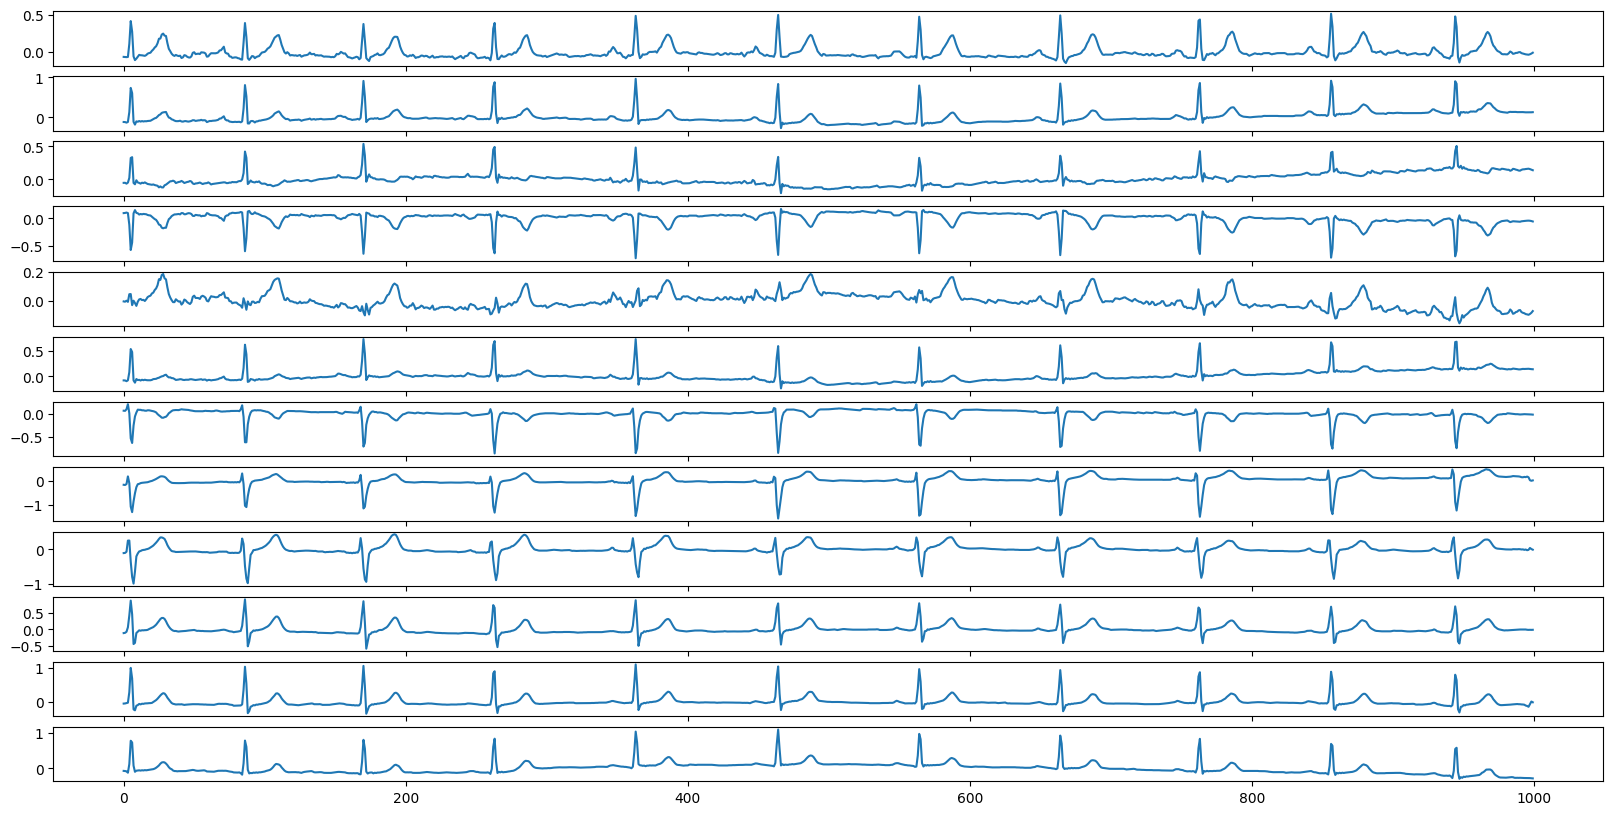

age                   48.0
sex                      0
height                 NaN
weight                95.0
nurse                  2.0
site                   0.0
device           CS-12   E
NORM                     0
MI                       1
STTC                     0
HYP                      0
CD                       0
sub_NORM                 0
sub_IMI                  1
sub_STTC                 0
sub_NST_                 0
sub_LVH                  0
sub_LAFB/LPFB            0
sub_RVH                  0
sub_IRBBB                0
sub_RAO/RAE              0
sub_IVCD                 0
sub_LMI                  0
sub_AMI                  0
sub__AVB                 0
sub_ISCA                 0
sub_ISC_                 0
sub_SEHYP                0
sub_ISCI                 0
sub_CRBBB                0
sub_CLBBB                0
sub_LAO/LAE              0
sub_ILBBB                0
sub_WPW                  0
sub_PMI                  0
strat_fold               9
Name: 8, dtype: object


In [118]:
mi_idx = y_all[y_all['MI'] == 1].index[0]
mi_sample = x_all[mi_idx+1]
bar, axes = plt.subplots(mi_sample.shape[1], 1, figsize=(20, 10))
for i in range(mi_sample.shape[1]):
    sns.lineplot(x=np.arange(mi_sample.shape[0]), y=mi_sample[:, i], ax=axes[i])
plt.show()
print(y_all.loc[mi_idx])

STTC example

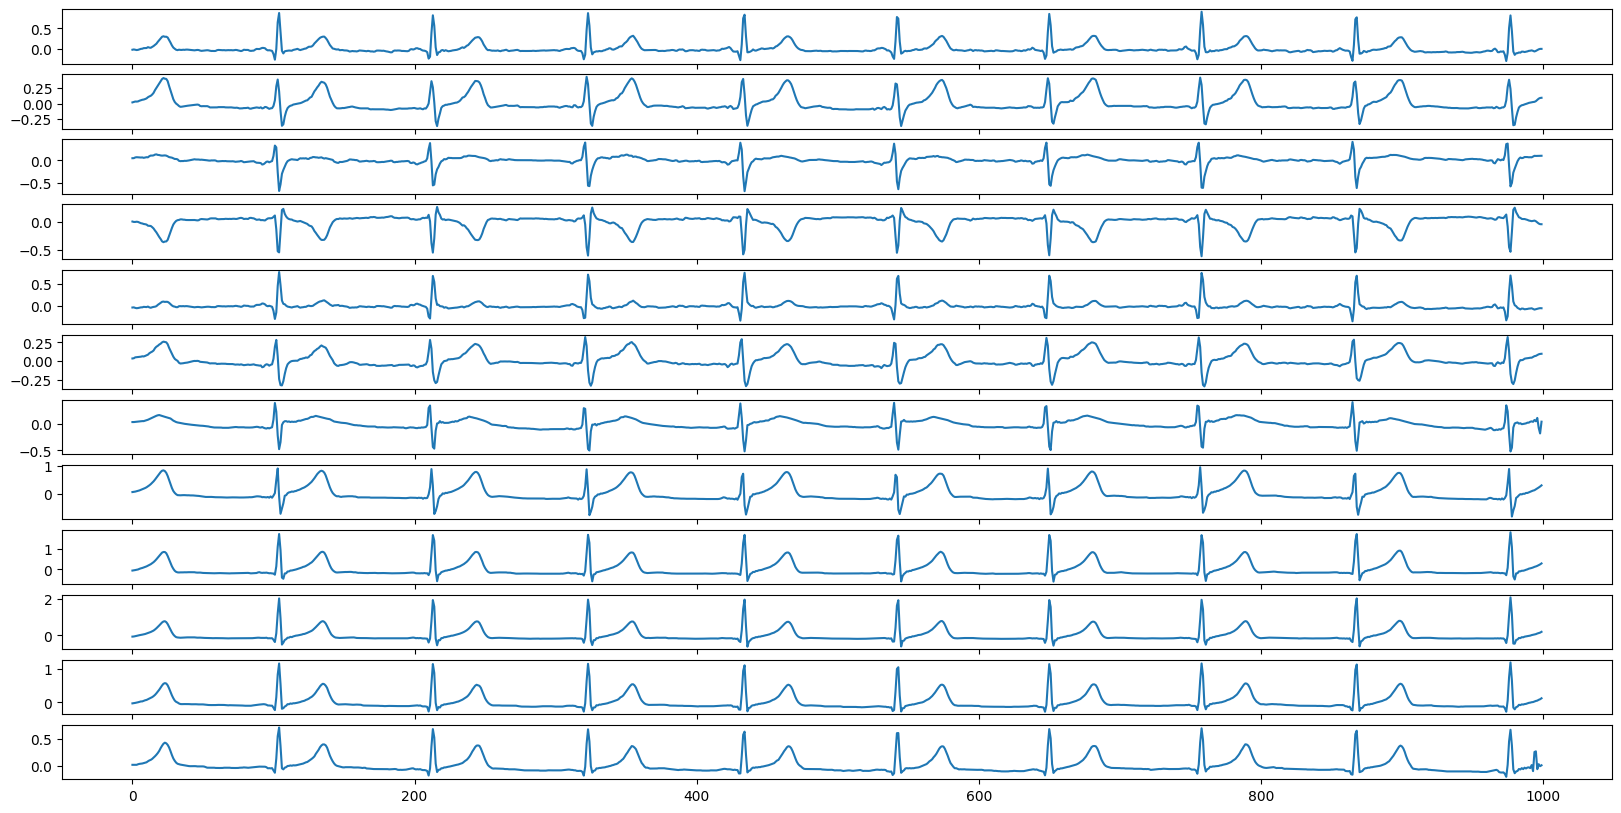

age                   17.0
sex                      1
height                 NaN
weight                53.0
nurse                  2.0
site                   0.0
device           CS-12   E
NORM                     0
MI                       0
STTC                     1
HYP                      0
CD                       0
sub_NORM                 0
sub_IMI                  0
sub_STTC                 1
sub_NST_                 0
sub_LVH                  0
sub_LAFB/LPFB            0
sub_RVH                  0
sub_IRBBB                0
sub_RAO/RAE              0
sub_IVCD                 0
sub_LMI                  0
sub_AMI                  0
sub__AVB                 0
sub_ISCA                 0
sub_ISC_                 0
sub_SEHYP                0
sub_ISCI                 0
sub_CRBBB                0
sub_CLBBB                0
sub_LAO/LAE              0
sub_ILBBB                0
sub_WPW                  0
sub_PMI                  0
strat_fold               4
Name: 22, dtype: object


In [107]:
sttc_idx = y_all[y_all['STTC'] == 1].index[0]
sttc_sample = x_all[sttc_idx+1]
bar, axes = plt.subplots(sttc_sample.shape[1], 1, figsize=(20, 10))
for i in range(sttc_sample.shape[1]):
    sns.lineplot(x=np.arange(sttc_sample.shape[0]), y=sttc_sample[:, i], ax=axes[i])
plt.show()
print(y_all.loc[sttc_idx])

CD: Conduction Disturbance example

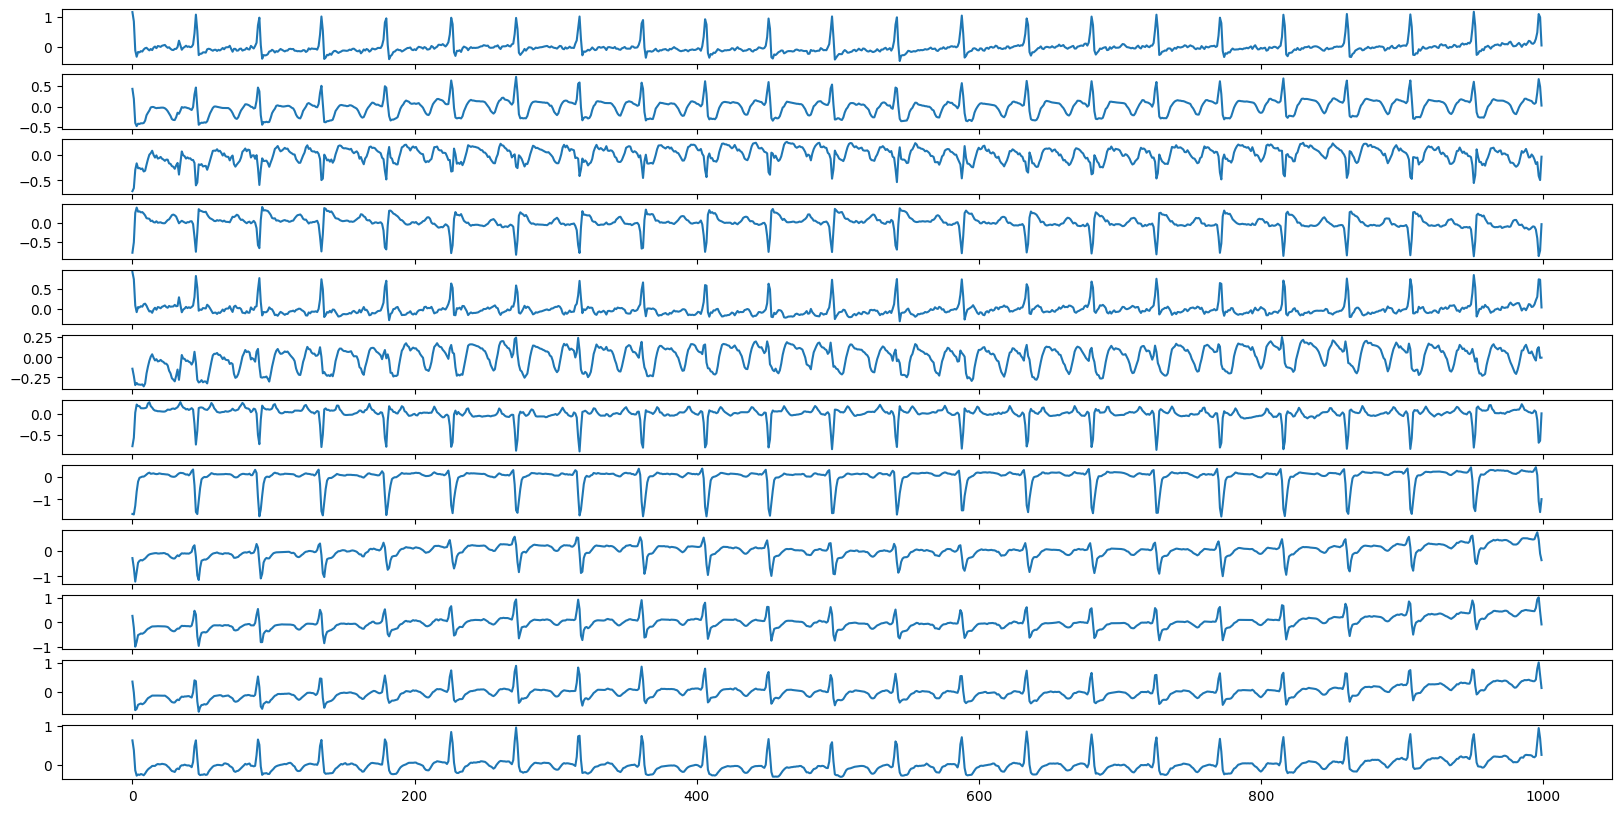

age                   18.0
sex                      0
height                 NaN
weight                56.0
nurse                  2.0
site                   0.0
device           CS-12   E
NORM                     0
MI                       0
STTC                     0
HYP                      0
CD                       1
sub_NORM                 0
sub_IMI                  0
sub_STTC                 0
sub_NST_                 0
sub_LVH                  0
sub_LAFB/LPFB            1
sub_RVH                  0
sub_IRBBB                0
sub_RAO/RAE              0
sub_IVCD                 0
sub_LMI                  0
sub_AMI                  0
sub__AVB                 0
sub_ISCA                 0
sub_ISC_                 0
sub_SEHYP                0
sub_ISCI                 0
sub_CRBBB                0
sub_CLBBB                0
sub_LAO/LAE              0
sub_ILBBB                0
sub_WPW                  0
sub_PMI                  0
strat_fold               1
Name: 32, dtype: object


In [109]:
cd_idx = y_all[y_all['CD'] == 1].index[0]
cd_sample = x_all[cd_idx+1]
bar, axes = plt.subplots(cd_sample.shape[1], 1, figsize=(20, 10))
for i in range(cd_sample.shape[1]):
    sns.lineplot(x=np.arange(cd_sample.shape[0]), y=cd_sample[:, i], ax=axes[i])
plt.show()
print(y_all.loc[cd_idx])

HYP: Hypertrophy example

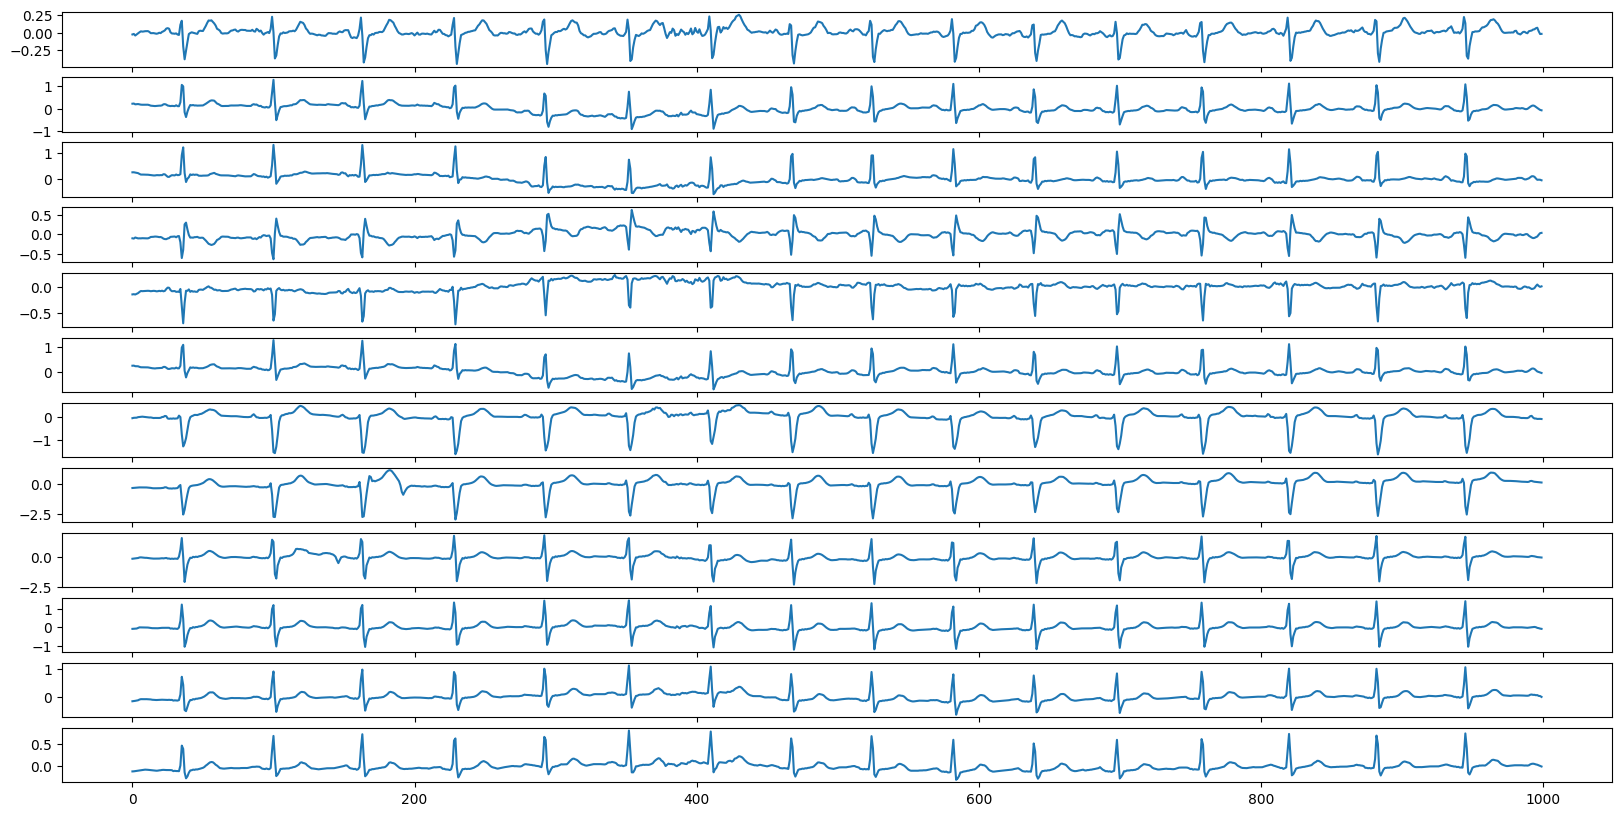

age                   25.0
sex                      0
height                 NaN
weight                83.0
nurse                  2.0
site                   0.0
device           CS-12   E
NORM                     0
MI                       0
STTC                     0
HYP                      1
CD                       0
sub_NORM                 0
sub_IMI                  0
sub_STTC                 0
sub_NST_                 0
sub_LVH                  1
sub_LAFB/LPFB            0
sub_RVH                  0
sub_IRBBB                0
sub_RAO/RAE              0
sub_IVCD                 0
sub_LMI                  0
sub_AMI                  0
sub__AVB                 0
sub_ISCA                 0
sub_ISC_                 0
sub_SEHYP                0
sub_ISCI                 0
sub_CRBBB                0
sub_CLBBB                0
sub_LAO/LAE              0
sub_ILBBB                0
sub_WPW                  0
sub_PMI                  0
strat_fold               9
Name: 30, dtype: object


In [110]:
hyp_idx = y_all[y_all['HYP'] == 1].index[0]
hyp_sample = x_all[hyp_idx+1]
bar, axes = plt.subplots(hyp_sample.shape[1], 1, figsize=(20, 10))
for i in range(hyp_sample.shape[1]):
    sns.lineplot(x=np.arange(hyp_sample.shape[0]), y=hyp_sample[:, i], ax=axes[i])
plt.show()
print(y_all.loc[hyp_idx])

## Data split

[Ref](https://physionet.org/content/ptb-xl/1.0.1/) the original dataset, we will use the strat_fold column to split the data. Fold 10 is recommended to be used as test set, which we will do. It is also noted that fold 9 and 10 are of higher quality, so we will use fold 9 as validation set and the rest as training set.

In [ ]:
# Train set
x_train, y_train = get_data_by_folds(np.arange(1, 9), X, Y, update_cols, meta_features)
print('x_train shape', x_train.shape)
y_train

x_train shape (17441, 1000, 12)


,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,0,...,0,0,0,0,0,0,0,0,0,7
21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,1,...,0,0,0,0,0,0,0,0,0,7
21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
# Validation set
x_valid, y_valid = get_data_by_folds([9], X, Y, update_cols, meta_features)
print('x_valid shape', x_valid.shape)
y_valid

x_valid shape (2193, 1000, 12)


,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
8,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,0,1,0,...,0,0,0,0,0,0,0,0,0,9
10,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,9
17,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,0,0,0,...,0,0,0,0,0,0,0,0,0,9
18,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,0,0,0,...,0,0,0,0,0,0,0,0,0,9
20,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21777,54.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,9
21788,72.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,1,0,...,0,0,0,0,0,0,0,0,0,9
21817,66.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [ ]:
# Test set
x_test, y_test = get_data_by_folds([10], X, Y, update_cols, meta_features)
print('data shape', x_test.shape)
y_test

data shape (2203, 1000, 12)


,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
9,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,10
38,40.0,0,NaN,72.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,10
40,60.0,0,NaN,85.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,10
57,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,10
59,54.0,0,NaN,67.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21809,69.0,1,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,10
21812,67.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,0,...,0,0,0,1,0,0,0,0,0,10
21818,84.0,1,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,10
